In [1]:
!pip install torch
!pip install torch-geometric
!pip install pickle5

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import pandas as pd
import torch, time, re, string
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.init as init
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from torch.nn import BatchNorm1d
from google.colab import files
import pickle
import matplotlib.pyplot as plt

In [3]:
start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device used: " + torch.cuda.get_device_name(0)) if torch.cuda.is_available() else print("CPU is used")

Device used: Tesla T4


In [4]:
dataset = files.upload()
dataset = pd.read_csv("augmented_final2.csv", encoding='latin-1')
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

#dataset = dataset[dataset['label'] != 0]

labels = dataset['label']
labels = labels.replace(3, 2)
labels = labels.replace(2, 0)


temp_df = pd.DataFrame({'Category':labels})

class_distribution = temp_df['Category'].value_counts(normalize = True)
#percentages = (class_distribution / len(temp_df)) * 100

print(class_distribution)
#N-3 (neutral)
#E-2 (emotion)
#I-1 (information)
#x-0 (irrelevant)
labels_tensor = torch.tensor(labels, dtype=torch.long)


Saving augmented_final2.csv to augmented_final2.csv
Category
0    0.511272
1    0.488728
Name: proportion, dtype: float64


In [5]:
uploaded = files.upload()

with open('embeddings_aug_irr2.pkl', 'rb') as f:
    embeddings = pickle.load(f)

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# # Function to get BERT embeddings for a given text
# def get_bert_embeddings(text):
#     tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
#     with torch.no_grad():
#         outputs = model(**tokens)
#     # Extract embeddings from the last layer
#     embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
#     return embeddings

# # Compute embeddings for each tweet and maintain a mapping
# embeddings = []
# node_mapping = {}  # To map node index to tweet index
# for i, text in enumerate(dataset['Text']):
#     # Get BERT embeddings for the text
#     embedding = get_bert_embeddings(text)

#     # Append the embeddings to the list
#     embeddings.append(embedding)

#     # Map node index to tweet index
#     node_mapping[i] = text

# # Convert embeddings to a numpy array
# embeddings_array = np.array(embeddings)



Saving embeddings_aug_irr2.pkl to embeddings_aug_irr2.pkl


In [6]:
# with open('embeddings_aug_irr2.pkl', 'wb') as f:
#     pickle.dump(embeddings, f)

# files.download('embeddings_aug_irr2.pkl')

In [7]:
# try:
#     embeddings_tensor_cpu = torch.stack(embeddings)
#     print("Stacking on CPU successful.")
# except Exception as e:
#     print(f"Error stacking on CPU: {e}")

#Convert embeddings to a tensor
# embeddings = torch.tensor(embeddings)
embeddings_tensor = torch.stack(embeddings).to(device)

In [8]:
print(embeddings_tensor.shape)

# if len(embeddings_tensor) > 0:
#     cos_sim_matrix = F.cosine_similarity(embeddings_tensor.cpu(), embeddings_tensor.cpu())
# else:
#     raise ValueError("Embeddings not found, check dataset")

# Compute average cosine similarity
# avg_cos_sim = torch.mean(cos_sim_matrix)

# Create adjacency matrix based on cosine similarities
num_tweets = len(dataset)
embeddings_cpu = embeddings_tensor.cpu()
embeddings_numpy = embeddings_cpu.detach().numpy()

# Compute pairwise cosine similarities
cos_sim_matrix = cosine_similarity(embeddings_numpy)
negative_indices = cos_sim_matrix < 0

# upper_tri_indices = np.triu_indices_from(cos_sim_matrix, k=1)
# cos_sim_values = cos_sim_matrix[upper_tri_indices]

cos_sim_matrix = np.square(cos_sim_matrix)
#cos_sim_matrix[negative_indices] *= -1

# Compute the average cosine similarity
avg_cos_sim = torch.tensor(cos_sim_matrix.mean())

cos_sim_matrix = torch.tensor(cos_sim_matrix)
std_dev_cos_sim = torch.tensor(cos_sim_matrix.std())
print(f"average = {avg_cos_sim}")
print(f"std dev = {std_dev_cos_sim}")

# Apply thresholding condition
factor1 = 1
#factor2 = 3
threshold1 = (avg_cos_sim) + (factor1 * std_dev_cos_sim)

#threshold2 = (avg_cos_sim) - (factor2 * std_dev_cos_sim)
#cos_sim_matrix[(cos_sim_matrix < threshold1)] = 0
#cos_sim_matrix[cos_sim_matrix < threshold2] = -1 * cos_sim_matrix[cos_sim_matrix < threshold2]

# Create adjacency matrix
num_texts = embeddings_tensor.size(0)
adjacency_matrix = torch.tensor(cos_sim_matrix, dtype=torch.float32, device=embeddings_tensor.device)


# Set diagonal elements to zero
adjacency_matrix.fill_diagonal_(0)

# Convert negative values to zero (cosine similarity should be between 0 and 1)
adjacency_matrix = torch.clamp(adjacency_matrix, min=0)

# If you want to ensure the adjacency matrix is symmetric
adjacency_matrix = (adjacency_matrix + adjacency_matrix.t()) / 2

print("Shape: ", adjacency_matrix.shape)
num_negative_indices = np.sum(negative_indices)

print(f'Number of negative indices: {num_negative_indices}')
# Extract upper triangular part of the cosine similarity matrix
# upper_triangular = torch.triu(cos_sim_matrix, diagonal=1)
# print("Shape of upper_triangular:", upper_triangular.shape)

torch.Size([6210, 768])


<ipython-input-8-be6f27582d1f>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_dev_cos_sim = torch.tensor(cos_sim_matrix.std())
<ipython-input-8-be6f27582d1f>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adjacency_matrix = torch.tensor(cos_sim_matrix, dtype=torch.float32, device=embeddings_tensor.device)


average = 0.4648229777812958
std dev = 0.1319354921579361
Shape:  torch.Size([6210, 6210])
Number of negative indices: 6


In [9]:
# row_indices, col_indices = torch.nonzero(upper_triangular >= avg_cos_sim, as_tuple=True)

# # Collect edges and cosine similarities
# edges = [(i, j, upper_triangular[i, j].item()) for i, j in zip(row_indices, col_indices)]


edges = []
index = 0
# for i in range(num_tweets):
#     for j in range(i+1, num_tweets):
#         #if index >= len(cos_sim_matrix):  # Check if the index is within bounds
#         #    break  # If index exceeds bounds, break the loop
#         cos_sim = cos_sim_matrix[index].item()  # Extract cosine similarity value
#         #if cos_sim >= avg_cos_sim:
#         edges.append((i, j, cos_sim))
#         index += 1

# for edge in edges:
#     i, j, cos_sim = edge
#     adjacency_matrix[i, j] = cos_sim
#     adjacency_matrix[j, i] = cos_sim

# Convert adjacency_matrix_tensor to PyTorch tensor if not already
adjacency_matrix_tensor = torch.tensor(adjacency_matrix)

# Set diagonal elements to zero
adjacency_matrix_tensor.fill_diagonal_(0)

# Ensure the adjacency matrix is symmetric
adjacency_matrix_tensor = (adjacency_matrix_tensor + adjacency_matrix_tensor.t()) / 2

# Convert adjacency matrix to a PyTorch tensor if it's not already
if not isinstance(adjacency_matrix_tensor, torch.Tensor):
    adjacency_matrix_tensor = torch.tensor(adjacency_matrix_tensor)

# Flatten the upper triangular part of the adjacency matrix (excluding diagonal)
num_nodes = adjacency_matrix_tensor.shape[0]
edge_weights = adjacency_matrix_tensor[torch.triu(torch.ones(num_nodes, num_nodes), diagonal=1) == 1]

# Create edge_weights_tensor
edge_weights_tensor = edge_weights.flatten()

print(edge_weights_tensor.shape)

# If you want to ensure that the adjacency matrix is symmetric (in case it's not already):
#adjacency_matrix = np.maximum(adjacency_matrix, adjacency_matrix.T)

<ipython-input-9-e0f71af9bbe7>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adjacency_matrix_tensor = torch.tensor(adjacency_matrix)


torch.Size([19278945])


In [10]:
#adjacency_matrix_tensor = torch.tensor(adjacency_matrix).to(device)
# Get the upper triangular part of the adjacency matrix excluding the diagonal
upper_triangular = torch.triu(adjacency_matrix_tensor, diagonal=1)

# Find the indices of non-zero entries
edge_indices = torch.nonzero(upper_triangular, as_tuple=False)

# Transpose the edge indices to have the shape (2, num_edges) where the first row represents the source nodes
# and the second row represents the target nodes of each edge
edge_index = edge_indices.t()

print(edge_index.shape)

#filtered_edge_index = edge_index[:, cos_sim_matrix[edge_index[0], edge_index[1]] >= avg_cos_sim]
print(labels_tensor.shape)

data = Data(x=embeddings_tensor, edge_index=edge_index, edge_attr=edge_weights_tensor, y=labels_tensor)

# Split dataset into train, validation, and test sets
# train_idx, test_idx = train_test_split(range(len(data.y)), test_size=0.2, random_state=42)
# train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)

train_idx, remaining_idx = train_test_split(range(len(data.y)), test_size=0.3, random_state=42, stratify=labels)

remaining_labels = labels[remaining_idx]
test_idx, val_idx = train_test_split(remaining_idx, test_size=0.5, random_state=42, stratify=remaining_labels)

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(data.y), dtype=torch.bool).to(device)
val_mask = torch.zeros(len(data.y), dtype=torch.bool).to(device)
test_mask = torch.zeros(len(data.y), dtype=torch.bool).to(device)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

labels_np = data.y.cpu().numpy()

# Function to count label occurrences in each mask
def count_labels(mask, labels):
    masked_labels = labels[mask.cpu().numpy()]
    label_0_count = (masked_labels == 0).sum()
    label_1_count = (masked_labels == 1).sum()
    return label_0_count, label_1_count

# Count labels in each set
train_label_0_count, train_label_1_count = count_labels(train_mask, labels_np)
val_label_0_count, val_label_1_count = count_labels(val_mask, labels_np)
test_label_0_count, test_label_1_count = count_labels(test_mask, labels_np)

print(f"Train set - Label 0: {train_label_0_count}, Label 1: {train_label_1_count}")
print(f"Validation set - Label 0: {val_label_0_count}, Label 1: {val_label_1_count}")
print(f"Test set - Label 0: {test_label_0_count}, Label 1: {test_label_1_count}")


torch.Size([2, 19278945])
torch.Size([6210])
Train set - Label 0: 2222, Label 1: 2125
Validation set - Label 0: 477, Label 1: 455
Test set - Label 0: 476, Label 1: 455


In [11]:
# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout_rate=0.5, weight_decay=0.01):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.normalize(x, p=2, dim=-1)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        #return F.softmax(x, dim=1)
        return torch.sigmoid(x)


In [12]:
# Initialize model, criterion, and optimizer
hidden_channels = 16
dropout_rate=0.3
weight_decay=0.0001
#lr=1e-5
lr=0.000055
num_classes=2

model = GCN(data.num_features, hidden_channels, num_classes, dropout_rate,weight_decay).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=weight_decay)  # Adding weight decay

In [13]:
def train(model, data, train_mask, optimizer, criterion, device, batch_size):
    model.train()
    data = data.to(device)
    num_data_points = train_mask.sum().item()
    num_batches = int(np.ceil(num_data_points / batch_size))

    total_loss = 0.0
    for batch in range(num_batches):
        optimizer.zero_grad()

        # Create batch masks
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, num_data_points)
        batch_mask = train_mask[start_idx:end_idx]


        # Forward pass
        out = model(data.x, data.edge_index)
        loss = criterion(out[train_mask], data.y[train_mask])

        #Adding L2 regularization
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)

        #loss += model.weight_decay * l2_reg

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_mask.sum().item() / num_data_points

    return total_loss


In [14]:
def test(model, data, mask, device):
    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        data = data.to(device)
        pred = model(data.x, data.edge_index).max(dim=1)[1]

    # Calculate accuracy and confusion matrix
    acc = accuracy_score(data.y[mask].cpu().numpy(), pred[mask].cpu().numpy())
    cm = confusion_matrix(data.y[mask].cpu().numpy(), pred[mask].cpu().numpy())
    return acc, cm

def validate(model, data, val_mask, criterion, device):
    model.eval()
    data = data.to(device)

    with torch.no_grad():
        # Forward pass
        out = model(data.x, data.edge_index)
        loss = criterion(out[val_mask], data.y[val_mask])

    return loss.item()

# # Define and move model to device
# model = GCN(num_features=data.num_features, hidden_channels=16, num_classes=4).to(device)

# # Define optimizer and criterion
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# Move data and masks to device
data = data.to(device)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)

In [15]:
history = {
    'loss_values_train': [],
    'val_loss': [],
    'training_accuracy': [],
    'validation_accuracy': [],
}

batch_size=32
epochs=250

# Training loop
for epoch in range(epochs):
    train_loss = train(model, data, train_mask, optimizer, criterion, device, batch_size)
    val_acc, val_cm = test(model, data, val_mask, device)
    train_acc, _ = test(model, data, train_mask, device)
    val_loss_item = validate(model, data, val_mask, criterion, device)
    history['loss_values_train'].append(train_loss)
    history['val_loss'].append(val_loss_item)
    history['training_accuracy'].append(train_acc)
    history['validation_accuracy'].append(val_acc)
    #if((epoch+1)%10==0):
    print(f'Epoch: {epoch+1:03d}, Loss: {train_loss:.4f}, Validation Acc: {val_acc:.4f}, Training Acc: {train_acc:.4f}')

Epoch: 001, Loss: 0.4830, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 002, Loss: 0.4830, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 003, Loss: 0.4830, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 004, Loss: 0.4830, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 005, Loss: 0.4829, Validation Acc: 0.5118, Training Acc: 0.5114
Epoch: 006, Loss: 0.4829, Validation Acc: 0.5118, Training Acc: 0.5114
Epoch: 007, Loss: 0.4829, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 008, Loss: 0.4829, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 009, Loss: 0.4829, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 010, Loss: 0.4829, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 011, Loss: 0.4829, Validation Acc: 0.5107, Training Acc: 0.5121
Epoch: 012, Loss: 0.4829, Validation Acc: 0.5172, Training Acc: 0.5144
Epoch: 013, Loss: 0.4829, Validation Acc: 0.5118, Training Acc: 0.5112
Epoch: 014, Loss: 0.4829, Validation Acc: 0.5150, Training Acc: 0.5130
Epoch:

In [16]:
# Test the model
test_acc, test_cm = test(model, data, test_mask, device)
#end_time = time.time()
print(f'Test Accuracy: {test_acc:.4f}')
print('Test Confusion Matrix:')
print(test_cm)
#time = (end_time - start_time) / 60.0
#print(f'Total time taken = {time:.4f}')
print(f'Dropout rate: {dropout_rate} Hidden Channels: {hidden_channels} Learning Rate: {lr} Batch Size: {batch_size} Epochs: {epochs} Threshold: Avg + {factor1} * std dev')
precision = test_cm[1][1] /(test_cm[1][0] + test_cm[1][1])
recall = test_cm[1][1] / (test_cm[1][1] + test_cm[0][1])
f1 = 2 * precision * recall / (precision + recall)
print(f'Precision: {precision} Recall: {recall} F1 Score: {f1}')

num_edges = edge_index.shape[1]
total_edges = (num_nodes * (num_nodes - 1)) / 2
graph_density = num_edges / total_edges
print(f'Density of the graph: {graph_density}')


Test Accuracy: 0.5070
Test Confusion Matrix:
[[454  22]
 [437  18]]
Dropout rate: 0.3 Hidden Channels: 16 Learning Rate: 5.5e-05 Batch Size: 32 Epochs: 250 Threshold: Avg + 1 * std dev
Precision: 0.03956043956043956 Recall: 0.45 F1 Score: 0.07272727272727272
Density of the graph: 1.0


In [17]:
# Save the history to a file
with open('model_history(fully_connected2).pkl', 'wb') as f:
    pickle.dump(history, f)

# Download the file to the local system
files.download('model_history(fully_connected2).pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

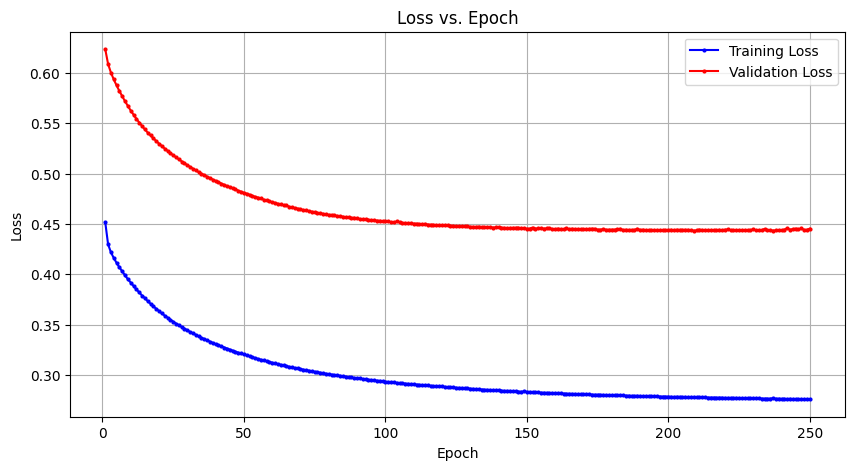

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), loss_values, marker='o', linestyle='-', label='Training Loss',color='b', markersize=2)
plt.plot(range(1, epochs+1), val_loss, marker='o', linestyle='-', label='Validation Loss',color='r', markersize=2)
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)


# plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs+1), training_accuracy, marker='o', linestyle='-', color='b')
# plt.title('Training Accuracy vs. Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.grid(True)

# plt.show()
# epoch_array = []
# for i in range(epochs):
#   epoch_array.append(i)

# !pip install plotly==5.22.0
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=epoch_array, y=loss_values, mode='lines+markers'))
# fig.update_layout(title='Loss Variation', xaxis_title='Epochs', yaxis_title='Loss')
# fig.update_layout(
#     title='Loss Variation',
#     xaxis_title='Epochs',
#     yaxis_title='Loss',
#     plot_bgcolor='white',
#     paper_bgcolor='white',
#     xaxis=dict(
#         showgrid=True,      # Show grid lines for x-axis
#         gridcolor='black',  # Set grid line color for x-axis
#         gridwidth=1,        # Set grid line width for x-axis
#         zeroline=True,      # Ensure zero line is shown
#         zerolinecolor='black', # Set zero line color for x-axis
#         zerolinewidth=1
#     ),
#     yaxis=dict(
#         showgrid=True,      # Show grid lines for x-axis
#         gridcolor='black',  # Set grid line color for x-axis
#         gridwidth=1,        # Set grid line width for x-axis
#         zeroline=True,      # Ensure zero line is shown
#         zerolinecolor='black', # Set zero line color for x-axis
#         zerolinewidth=1
#     )
# )


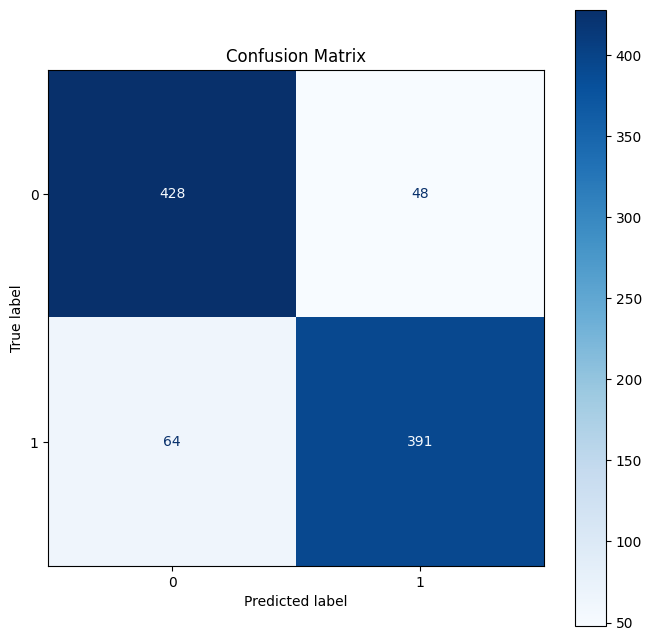

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(test_cm).plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
fig = go.Figure()

# Scatter plot trace for Quantity A
fig.add_trace(
    go.Scatter(
        x=epoch_array,
        y=training_accuracy,
        mode='lines+markers',
        name='Training Accuracy',  # Legend label for Quantity A
        marker=dict(color='blue')  # Set color for Quantity A
    )
)

# Scatter plot trace for Quantity B
fig.add_trace(
    go.Scatter(
        x=epoch_array,
        y=validation_accuracy,
        mode='lines+markers',
        name='Validation Accuracy',  # Legend label for Quantity B
        marker=dict(color='red')  # Set color for Quantity B
    )
)
fig.update_layout(
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        showgrid=True,      # Show grid lines for x-axis
        gridcolor='black',  # Set grid line color for x-axis
        gridwidth=1,        # Set grid line width for x-axis
        zeroline=True,      # Ensure zero line is shown
        zerolinecolor='black', # Set zero line color for x-axis
        zerolinewidth=1
    ),
    yaxis=dict(
        showgrid=True,      # Show grid lines for x-axis
        gridcolor='black',  # Set grid line color for x-axis
        gridwidth=1,        # Set grid line width for x-axis
        zeroline=True,      # Ensure zero line is shown
        zerolinecolor='black', # Set zero line color for x-axis
        zerolinewidth=1
    )
)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=epoch_array, y=validation_accuracy, mode='lines+markers'))
fig.update_layout(title='Validation Accuracy Variation', xaxis_title='Epochs', yaxis_title='Validation Accuracy')